In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train

y_train = [x[0] for x in y_train]
y_train = np.array(y_train)
y_train

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

In [4]:
# import numpy as np 

# def partially_corrupt_labels(y_train, corruption_level=0.1):
#     n_samples = len(y_train)
#     n_corrupt = int(corruption_level * n_samples)

    
#     corrupt_indices = np.random.choice(n_samples, n_corrupt, replace=False)

#     #New labels 
#     new_labels = np.random.choice(9, n_corrupt)

#     y_train_corrupted = y_train.copy()
#     y_train_corrupted[corrupt_indices] = new_labels
#     return y_train_corrupted

# partially_corrupt_labels(y_train=y_train)

import numpy as np

def partially_corrupt_labels_one_hot(y_train, corruption_level=0.1):
    n_samples = len(y_train)
    n_corrupt = int(corruption_level * n_samples)
    corrupt_indices = np.random.choice(n_samples, n_corrupt, replace=False)
    
    # Assuming labels are one-hot encoded with 10 classes
    new_labels = np.random.choice(10, n_corrupt)
    
    y_train_corrupted = y_train.copy()
    print('new labels')
    print(new_labels.shape)

    new_labels.reshape(5000, -1)

    y_train_corrupted.reshape(5000, -1)


    y_train_corrupted[corrupt_indices] = new_labels
    return y_train_corrupted


In [5]:
y_train_c = partially_corrupt_labels_one_hot(y_train=y_train)
y_train_c

new labels
(5000,)


array([6, 7, 1, ..., 9, 1, 1], dtype=uint8)

In [6]:
X_train, X_valid, y_train_p , y_valid = train_test_split(X_train, y_train_c, test_size=0.1, random_state=0)

In [7]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train_p.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)


Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000,)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000,)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


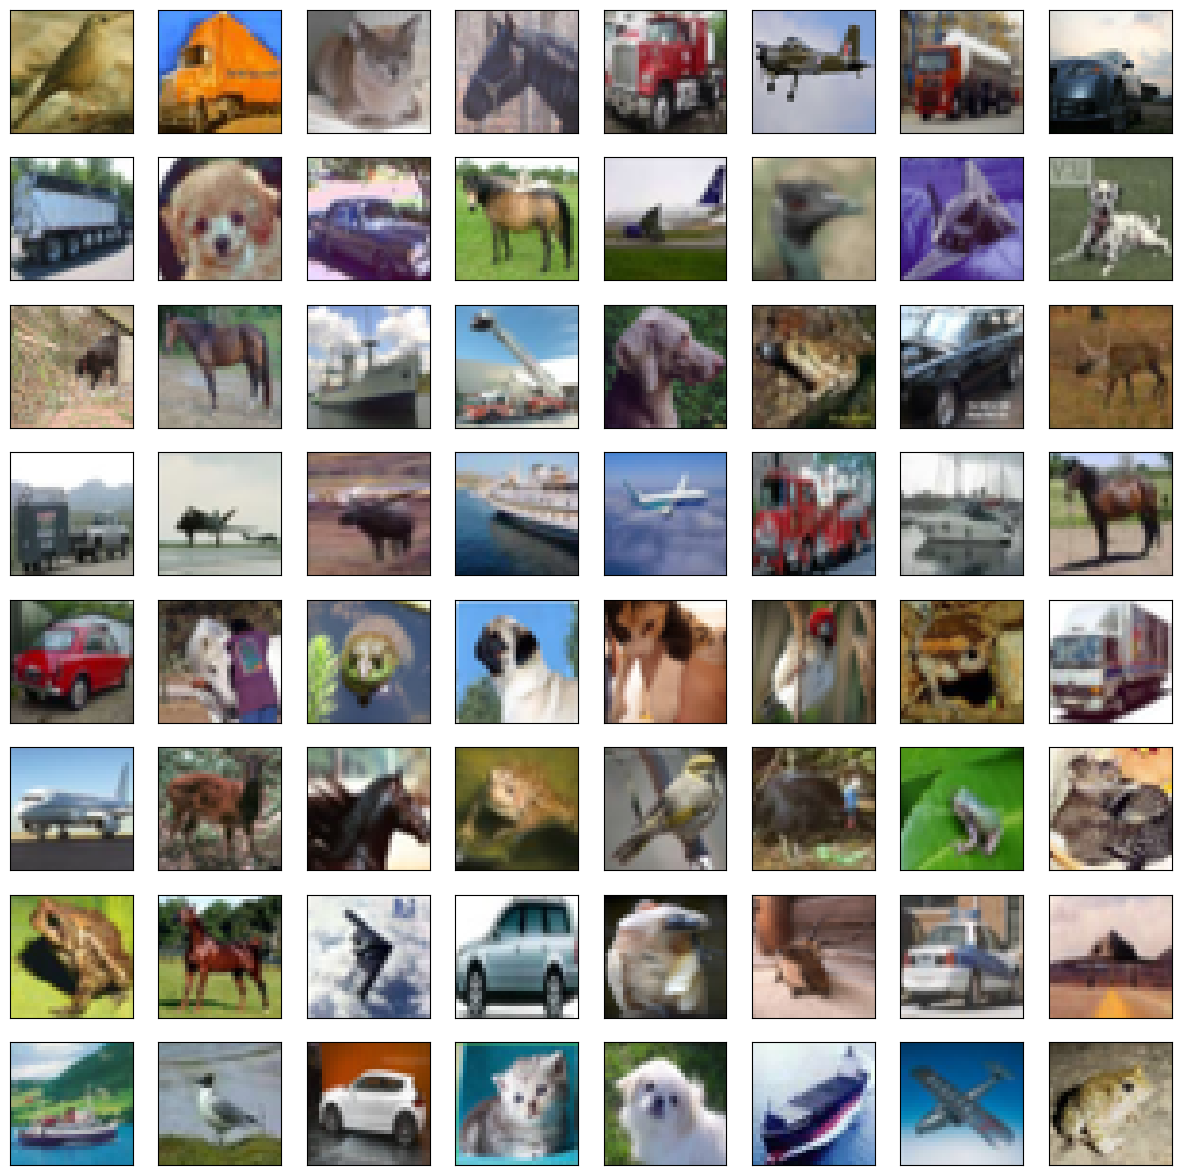

In [8]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    # plt.title(class_names[y_train_p[i][0]], fontsize=12)

# Display the figure
plt.show()

In [143]:
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

In [144]:
# y_train = to_categorical(y_train_p, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)
y_train_p = to_categorical(y_train_p, 10)

In [145]:
# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)

In [146]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

In [147]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_48 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_49 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                      

In [151]:
# Set the batch size for the training
batch_size = 64

# Set the maximum number of epochs for the training
epochs = 300

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 40 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
model.fit(data_generator.flow(X_train, y_train_p, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping], 
          verbose=2)

Epoch 1/300
704/704 - 49s - loss: 1.7909 - accuracy: 0.4837 - val_loss: 1.7976 - val_accuracy: 0.4944 - lr: 5.0000e-04 - 49s/epoch - 70ms/step
Epoch 2/300
704/704 - 38s - loss: 1.6549 - accuracy: 0.5244 - val_loss: 1.6407 - val_accuracy: 0.5774 - lr: 5.0000e-04 - 38s/epoch - 54ms/step
Epoch 3/300
704/704 - 36s - loss: 1.5688 - accuracy: 0.5577 - val_loss: 1.3783 - val_accuracy: 0.6028 - lr: 5.0000e-04 - 36s/epoch - 52ms/step
Epoch 4/300
704/704 - 36s - loss: 1.4971 - accuracy: 0.5801 - val_loss: 1.3690 - val_accuracy: 0.6142 - lr: 5.0000e-04 - 36s/epoch - 51ms/step
Epoch 5/300
704/704 - 36s - loss: 1.4492 - accuracy: 0.5999 - val_loss: 1.3637 - val_accuracy: 0.6508 - lr: 5.0000e-04 - 36s/epoch - 51ms/step
Epoch 6/300
704/704 - 36s - loss: 1.4032 - accuracy: 0.6168 - val_loss: 1.3356 - val_accuracy: 0.6420 - lr: 5.0000e-04 - 36s/epoch - 51ms/step
Epoch 7/300
704/704 - 36s - loss: 1.3649 - accuracy: 0.6323 - val_loss: 1.2966 - val_accuracy: 0.6696 - lr: 5.0000e-04 - 36s/epoch - 51ms/step

In [152]:
print(y_train_p.shape)
X_train.shape

(45000, 10)


(45000, 32, 32, 3)

In [153]:
print(model.history.history)

{'loss': [1.7908600568771362, 1.654895544052124, 1.5687885284423828, 1.4970650672912598, 1.4491732120513916, 1.4031552076339722, 1.3649094104766846, 1.3326627016067505, 1.3150779008865356, 1.302573561668396, 1.273524522781372, 1.2584176063537598, 1.2367539405822754, 1.237363338470459, 1.2162870168685913, 1.2080055475234985, 1.202174425125122, 1.1947489976882935, 1.1795381307601929, 1.1742786169052124, 1.1708706617355347, 1.163070797920227, 1.1531792879104614, 1.150613784790039, 1.1424694061279297, 1.1389830112457275, 1.132012128829956, 1.1271826028823853, 1.120767593383789, 1.1215269565582275, 1.1169142723083496, 1.113547921180725, 1.1081578731536865, 1.1070865392684937, 1.109754204750061, 1.102989912033081, 1.093094825744629, 1.0988893508911133, 1.0901328325271606, 1.0923304557800293, 1.0917202234268188, 1.091985821723938, 1.085371971130371, 1.0813429355621338, 1.075350284576416, 1.0758017301559448, 1.0759267807006836, 1.073175072669983, 1.0700597763061523, 1.0702964067459106, 1.06362

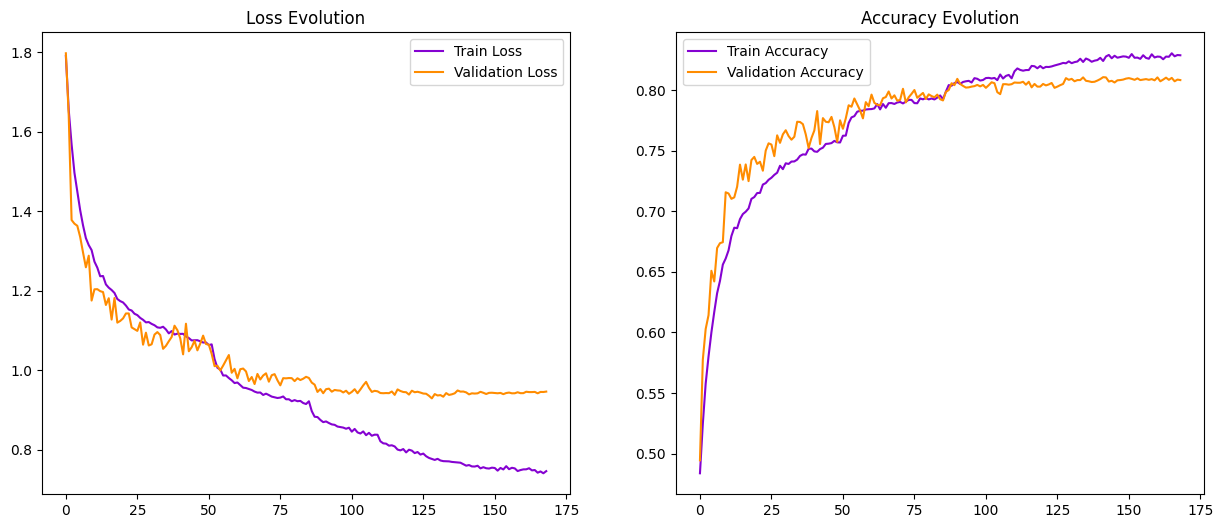

In [154]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [155]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 [==============================] - 3s 11ms/step - loss: 0.5319 - accuracy: 0.8806

Test Accuracy: 0.8805999755859375
Test Loss:     0.5318853855133057


In [156]:
# Fetch the raw image from GitHub
# url = "https://raw.githubusercontent.com/FarzadNekouee/Keras-CIFAR10-CNN-Model/master/truck_sample.png"
url = "https://github.com/YoongiKim/CIFAR-10-images/blob/master/test/frog/0005.jpg?raw=true"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

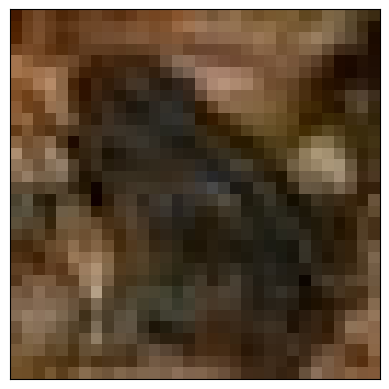

In [157]:
# Display the image
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [158]:
# Resize it to 32x32 pixels
image = cv2.resize(image, (32,32))

# Normalize the image
image = (image-mean)/(std+1e-7)

# Add an extra dimension because the model expects a batch of images
image = image.reshape((1, 32, 32, 3))

In [159]:
prediction = model.predict(image)

1/1 [==============================] - 1s 692ms/step


In [160]:
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

Predicted class:  frog


In [161]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 02:51:15
